In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from PIL import Image, ImageFilter, ImageEnhance

In [35]:
# 读入灰度图像
input_img = np.array(Image.open('./3.jpg').convert('L'), np.float32) / 255.0

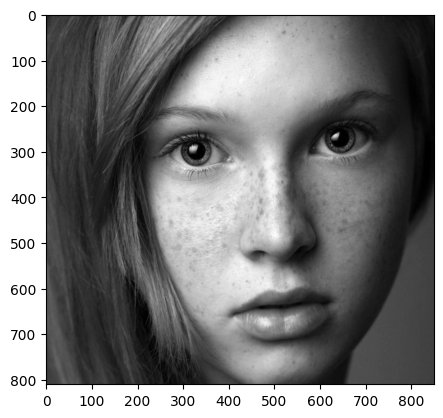

In [36]:
# 调整曝光度
ea_img = input_img * pow(2,-1.0)
plt.imshow(ea_img, cmap='gray')

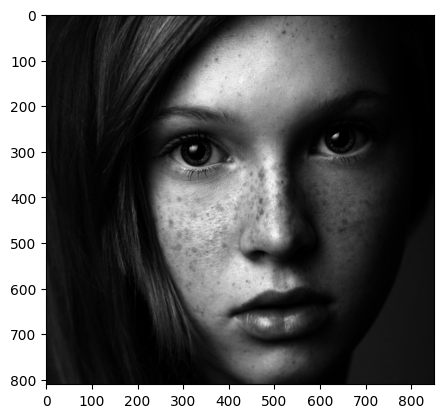

In [37]:
# 将绿色通道作为底图，蓝色通道作为叠加层
base = ea_img
overlay = ea_img
ba = 2.0*overlay*base
ba_img = np.zeros((ba.shape[0],ba.shape[1]),dtype=np.float32)
ba_img = ba

plt.imshow(ba_img,cmap='gray')

In [38]:
# 高斯卷积核尺寸(根据图像尺寸自动缩放)
radius = int(np.ceil(7.0*input_img.shape[0]/750.0))
radius

8

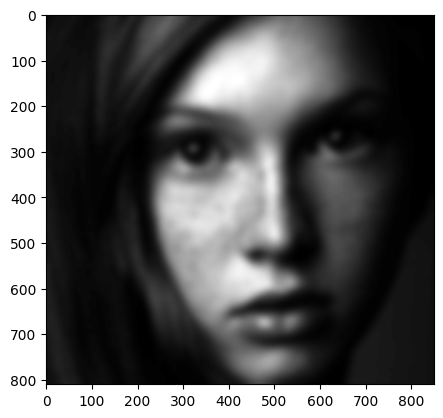

In [39]:
# 高斯模糊
pil_img = Image.fromarray(np.uint8(ba_img*255.0))
pil_blur = pil_img.filter(ImageFilter.GaussianBlur(radius))
blur_img = np.asarray(pil_blur,np.float32)/255.0
plt.imshow(blur_img,cmap='gray')

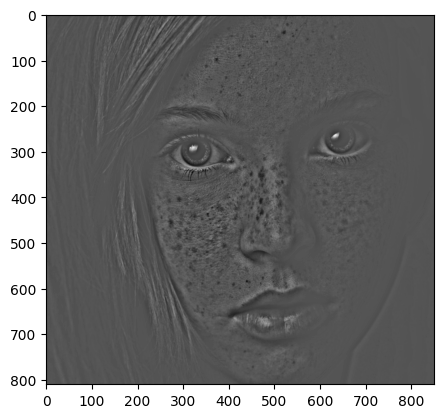

In [40]:
# 计算高反差保留图像,从原始图像中减去模糊图像并添加 0.5 灰度(8 位色深为 128)
hp_img = ba_img - blur_img + 0.5
plt.imshow(hp_img,cmap='gray')

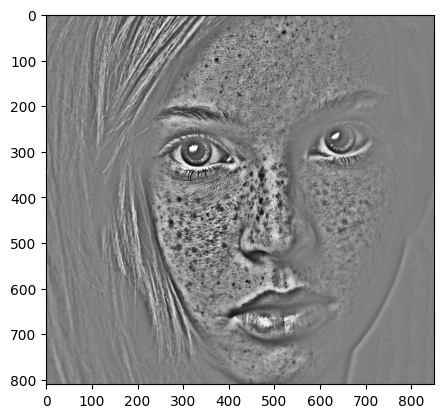

In [41]:
# 计算硬光混合后的图像
hardLightColor = hp_img
[x1,y1] = np.where(hardLightColor<0.5)
[x2,y2] = np.where(hardLightColor>=0.5)
for i in range(3):
    hardLightColor[x1,y1] = hardLightColor[x1,y1]*hardLightColor[x1,y1]*2.0
    hardLightColor[x2,y2] = 1.0 - (1.0 - hardLightColor[x2,y2]) * (1.0 - hardLightColor[x2,y2]) * 2.0
k = 255.0/(164.0-75.0)
hardLightColor = (hardLightColor - 75.0/255.0) * k
hpss_img = np.zeros((hardLightColor.shape[0],hardLightColor.shape[1]))
hpss_img = hardLightColor

plt.imshow(hpss_img,cmap='gray')

In [42]:
# 颜色曲线映射
x = [0,120.0/255.0,1]
y = [0,146.0/255.0,1]
cs = CubicSpline(x,y)
tc_img = cs(input_img)

In [43]:
tc_img

array([[0.20596079, 0.21099008, 0.21600678, ..., 0.15497555, 0.16013072,
        0.16013072],
       [0.21099008, 0.21600678, 0.21600678, ..., 0.15497555, 0.1652733 ,
        0.1652733 ],
       [0.21600678, 0.21600678, 0.2210109 , ..., 0.16013072, 0.1704033 ,
        0.1704033 ],
       ...,
       [0.31844977, 0.31844977, 0.31369741, ..., 0.31844977, 0.31369741,
        0.31369741],
       [0.32318954, 0.31844977, 0.31369741, ..., 0.32791675, 0.32318954,
        0.32318954],
       [0.32318954, 0.31844977, 0.31369741, ..., 0.32791675, 0.32318954,
        0.32318954]])

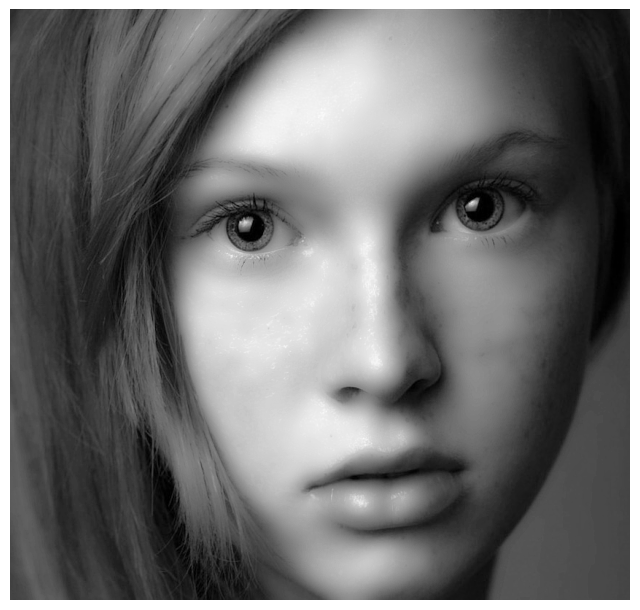

In [44]:
# 硬光混合和颜色曲线混合
blend_img = input_img * hpss_img + tc_img*(1-hpss_img)

# 图像锐化
enhancer = ImageEnhance.Sharpness(Image.fromarray(np.uint8(blend_img*255.0)))
img_sharp = enhancer.enhance(2)
result = np.array(img_sharp,np.float32)/255.0

# 显示结果
plt.figure(figsize=(8,8))
plt.imshow(result, cmap='gray')
plt.axis('off')
plt.show()

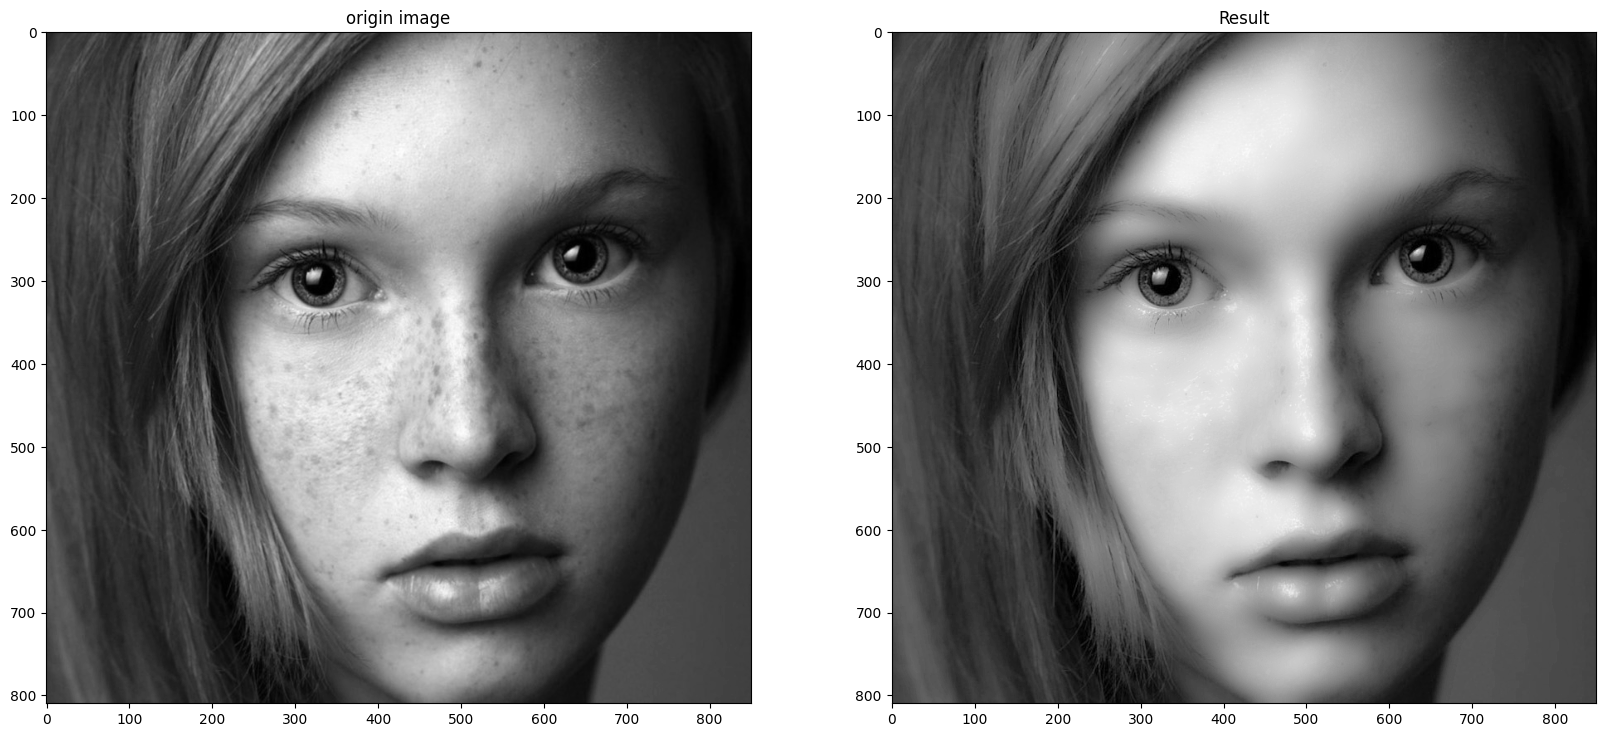

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
axs[0].imshow(input_img, cmap='gray')
axs[0].set_title('origin image')
axs[1].imshow(result, cmap='gray')
axs[1].set_title('Result')
plt.show()